In [4]:
import shallow_nn as nn
import optimized_tree as tr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import preprocessing
from collections import Counter

## Data importation

### Parser for the unirep files

In [5]:
def read_unirep(file_path):
    """
    Parse a Unirep file.
    """
    data_matrix = []
    with open(file_path) as fp:
        data = fp.readlines()
    for i, line in enumerate(data):
        if line[0] == '>':
            data_matrix.append(np.array(
                data[i + 1].strip().split(sep=' '),
                dtype=np.float64))
    return np.array(data_matrix)

### Dataset creation

Here, we will generate a dataset composed of 6000 samples: 3000 cytoplasmic proteins, and 3000 periplasmic proteins. The dataset for each class is first shuffled, then the 3000 first elements of each set are extracted onto the final dataset. This process is equivalent as random selection of samples.

In [6]:
# Imports unirep files.
raw_cyt = read_unirep("cytoxplasmUniRef50(1).unirep")
raw_peri = read_unirep("periplasmUniRef50(1).unirep")
# Shuffle imported data.
np.random.shuffle(raw_cyt)
np.random.shuffle(raw_peri)
# Creates mixed dataset (from shuffled = random selection).
all_raw = np.concatenate((raw_cyt[0:3000], raw_peri[0:3000]))

5998

Then, we scale the data, giving for each feature a mean = 0, and a standard deviation = 1. This makes the learning process easier for certain type of algorithms, for example for neural networks.

In [7]:
scaled_transfrom = preprocessing.scale(all_raw, axis=0)

1.0000000000000016


We then generate the labels for the dataset. The labels are kept in an array of the size of the dataset, and are given the value 1 for cytoplasmic proteins, or 0 for periplasmic ones.

In [8]:
# Gives value 1 to cytoplasmic proteins, 0 to others.
labels = np.zeros(len(all_raw), dtype=int)
labels[0:3000] = 1

## Neural network training

### Data preprocessing

The neural network we designed needs a one-hot encoding for the labels. One-hot encoding means that the value is stored in a sparse array, where all the values are 0 except the one corresponding the the class. For example, if there are 5 classes, an item with class 3 will be encoded as follows: [0, 0, 0, 1, 0, 0]. We designed a function that transfroms an array of integers to that format.

In [9]:
# One hot encoding for neural network.
def one_hot(labels):
    encoded_labels = []
    number_classes = len(set(labels))
    for item in labels:
        encoded = np.zeros(number_classes, dtype=int)
        encoded[item] = 1
        encoded_labels.append(encoded)
    return np.array(encoded_labels)

In [10]:
f_labels = one_hot(labels)

Then, the way the network is designed requires the data corresponding to a certain sample to be stored with it's label in an array, giving a dataset on the from [[sample1_values, sample1_label], [sample2_values, sample2_label], ...]. The following function adapts the data to this requirement.

In [11]:
# Prepares input for neural network.
def nn_input_format(dataset, labels):
    encoded_data = []
    for data, lab in zip(dataset, labels):
        value = (data.reshape((-1,1)), lab.reshape((-1,1)))
        encoded_data.append(value)
    return encoded_data

In [12]:
x = nn_input_format(scaled_transfrom, f_labels)

64

### Training step

Then, we proceed to training phase. Here, we will try to tune the hyperparameters to get the best accuracy. The parameters we will adjust are: the batch size, the $\eta$ value which is the learning rate, the $\lambda$ value which is the regularization parameter.

#### Cross validation 

To assess the accuracy of the network, we need to use k-fold cross validation. In k-fold cross validaton, the dataset is divided in k folds, and one fold is used as testing set while the others are used to train the classifier. One this step is done, the process is repeted using another fold as testing set and reimplementing the previous one in training process, and so on until all folds have been use.

In [33]:
# 10-fold cross validation.
def nn_10fold(arch, epoch, eta, batch_size, lbda):
    # Shuffle dataset.
    np.random.shuffle(x)
    n = len(x) / 10  # size of fold.
    tot_result = 0
    # trains and test on each fold.
    for i in range(10):
        network = nn.ShallowNetwork(arch)  # Initialize network.
        # Test fold.
        x_test_1 = x[int(i * n):int((i+1) * n)]
        # Train fold.
        x_train_1 = x[0:int(i * n)] + x[int((i+1) * n):]
        # Training step.
        network.stochastic_gradient_descent(x_train_1, epoch, batch_size, eta, lbda)
        # Current model score init.
        result = 0
        # Test phase using test set.
        for elt in x_test_1:
            result += network.predict(elt[0]) == np.where(elt[1] == 1)[0][0]
            result /= len(x_test_1)
            tot_result += result  # Adds fold result to total result.
    # Averages the results.
    final_res = tot_result / 10
    return (final_res)

#### Eta and batch size

First, we will assess the effect of the learning rate $\eta$ on the accuracy. $\eta$ is one of the most important parameters in the learning process of neural network. It defines how fast the network will learn from the gradient descent; too low, it will learn very slowly and need a longer training time to be able to make reliable predictions, too high it might miss the optimum by jumping from one side to the other due to too long steps.

We will try different values of $\eta$ for different batch size. The batch-size defines how many data points will be used to perform one step of gradien descent. Low batch size will take longer time to train, and larger batch size train the network less well. We use size that are power of 2 for purely computational purposes.

We will set the last parameter $\lambda$ to 0.5 for now because of computation time, and because we know be pre-testing it that at least it does not break the learning. We will come back on it afterwards.

In [34]:
results = []
lr = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9]
for eta in lr:
    # Parameter = architecture: 64 inputs, 32hn, 2 outputs(0 or 1).
    results.append(nn_10fold([64, 22, 2], 100, eta, 8, 0.5))

In [35]:
results

[0.9918138396809553,
 0.9938180151640352,
 0.9934830095906728,
 0.993483846639324,
 0.9946521827550742,
 0.9941533017714071,
 0.9934841262782484,
 0.9933169021979833,
 0.9943194091633256,
 0.9946530198075985]

In [36]:
results_2 = []
lr = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9]
for eta in lr:
    # Parameter = architecture: 64 inputs, 32hn, 2 outputs(0 or 1).
    results_2.append(nn_10fold([64, 22, 2], 100, eta, 16, 0.5))

In [37]:
results_2

[0.9898096637294949,
 0.9923143952341837,
 0.9929832915537082,
 0.9936513503585171,
 0.9929844082420581,
 0.9936516295306038,
 0.9943196883354133,
 0.9946521822913359,
 0.9938185744387846,
 0.9939855193469664]

In [38]:
results_3 = []
lr = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7, 0.9]
for eta in lr:
    # Parameter = architecture: 64 inputs, 32hn, 2 outputs(0 or 1).
    results_3.append(nn_10fold([64, 22, 2], 100, eta, 32, 0.5))

In [39]:
results_3

[0.9881413308723073,
 0.9913138415413331,
 0.9924821776570797,
 0.9928163466455301,
 0.992817463333879,
 0.9936502336701674,
 0.9931507948068423,
 0.9923163494372504,
 0.9929841290699706,
 0.9946527406355118]

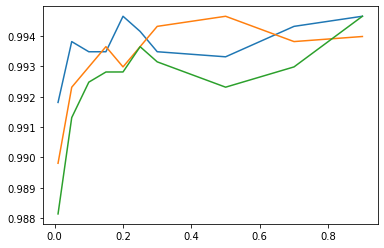

In [40]:
plt.plot(lr, results)
plt.plot(lr, results_2)
plt.plot(lr, results_3)

In [41]:
#nn_10fold([64, 32, 2], 0.2)

#### Lambda

Then, we can try different values of $\lambda$ and see how it changes the accuracy. 

In [43]:
results_4 = []
lb = [0.01, 0.03, 0.05, 0.7, 0.1, 0.15, 0.2, 0.25, 0.4, 0.6]
for lbd in lb:
    results_4.append(nn_10fold([64, 22, 2], 100,  0.2, 8, lbd))

In [44]:
results_4

[0.9934849637945108,
 0.9924827360012545,
 0.9933174605421572,
 0.9938188536108727,
 0.994485795727331,
 0.9931505156339757,
 0.9934846846224229,
 0.9938180160953829,
 0.9944866332443703,
 0.9934844054511105]

We can see that the learning is not consistently changed by the regularization parameter, keeping it to 0.5 seems to be a good idea.

## Decion tree training

Now, let's take a look at decision tree.

### Data preprocessing

First, as for this algorithm we will need to use separated data and labels not as in neural network, we need another function to shuffle de data and lables by still keeping them paired.

In [45]:
# Shuffles data and lables the same way.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Training step

Here is a simple tree, to see how it presents.

In [46]:
# Single model training for visualisation of the architecture.
new_scaled, new_labels = unison_shuffled_copies(scaled_transfrom, labels)
dt = tr.DecisionTree(new_scaled, new_labels, tr.CostFunction.gini, 5)
dt

`- Split(feature=41, value=-0.1807, score=0.8765), Classes: {1: 3000, 0: 2998}
   |- Split(feature=60, value=-0.7723, score=0.9391), Classes: {1: 2876, 0: 276}
   |  |- Split(feature=32, value=-0.8111, score=0.9729), Classes: {0: 196, 1: 20}
   |  |  |- Split(feature=50, value=-0.9239, score=1.0), Classes: {1: 18, 0: 1}
   |  |  |  |- 0, Classes: {0: 1}
   |  |  |  `- 1, Classes: {1: 18}
   |  |  `- Split(feature=55, value=-0.414, score=1.0), Classes: {0: 195, 1: 2}
   |  |     |- 1, Classes: {1: 2}
   |  |     `- 0, Classes: {0: 195}
   |  `- Split(feature=33, value=-0.1661, score=0.959), Classes: {1: 2856, 0: 80}
   |     |- Split(feature=62, value=-0.6359, score=0.8632), Classes: {1: 22, 0: 32}
   |     |  |- Split(feature=2, value=1.5285, score=0.9394), Classes: {1: 20, 0: 2}
   |     |  |  |- 1, Classes: {1: 19}
   |     |  |  `- 0, Classes: {0: 2, 1: 1}
   |     |  `- Split(feature=61, value=0.8879, score=0.9583), Classes: {1: 2, 0: 30}
   |     |     |- 0, Classes: {0: 29}
   | 


Decision tree trained with 5998 samples, 2 classes

Then, we define a cross-validation function for the trees classifiers.

In [47]:
# 10-fold cross-validation for decision trees.
def dt_10fold(depth):
    # Shuffles dataset.
    new_scaled, new_labels = unison_shuffled_copies(scaled_transfrom, labels)
    n = len(new_scaled) / 10  # Size of fold.
    tot_result = 0
    # Trains and test on each fold.
    for i in range(10):
        # Training data and labels.
        x_train_2 = np.concatenate((new_scaled[0:int(i * n)], new_scaled[int((i+1) * n):]), axis=0)
        x_labs_train = np.concatenate((new_labels[0:int(i * n)], new_labels[int((i+1) * n):]), axis=0)
        # Test data and labels.
        x_test_2 = new_scaled[int(i * n):int((i+1) * n)]
        x_labs_test = new_labels[int(i * n):int((i+1) * n)]
        # Model generation.
        dt = tr.DecisionTree(x_train_2, x_labs_train, tr.CostFunction.gini, depth)
        result = 0  # Fold result init.
        for elt, lab in zip(x_test_2, x_labs_test):
            result += dt.predict(elt) == lab
            result /= len(x_test_2)
            tot_result += result  # Adds fold result to total result.
    # Averages the results.
    final_res = tot_result / 10
    return (final_res)

We then try to generate trees with different depths to see how it affects the learning.

In [48]:
tree_res = []
dep = [2, 3, 4, 5, 6]
for d in dep:
    tree_res.append(dt_10fold(d))
    print(tree_res[-1])

0.9624206485966618
0.9764493251495863
0.9791187681849822
0.9801243460425197
0.9811257363195101


In [49]:
# Data segmentation, 75% training, 25% test.
new_scaled, new_labels = unison_shuffled_copies(scaled_transfrom, labels)
training_data, test_data = new_scaled[0:4500], new_scaled[4500:]
training_labels, test_labels = new_labels[0:4500], new_labels[4500:]

In [50]:
# Random forest
predictions = [Counter({0: 0, 1: 0}) for elt in test_data]
for i in range(300):
    weak_tree = tr.DecisionTree(training_data, training_labels, tr.CostFunction.gini, 5, True)
    for j, elt in enumerate(test_data):
        y_hat = weak_tree.predict(elt)
        predictions[j][y_hat] += 1

In [51]:
# Gets the most common prediciton for each point of the test set.
final_pred = np.array([elt.most_common(1)[0][0] for elt in predictions])
# Compares to true values and get the proportion of correctly predicted.
accuracy = sum([true == expected for true, expected in zip(test_labels, final_pred)]) / len(final_pred)

In [52]:
accuracy

0.9766355140186916

Accuracy of random forest is still below the neural network's one.